# **Imports**

In [20]:
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt

- **numpy:** Used for numerical operations and array manipulations.
- **librosa:** Core audio processing library for feature extraction and signal processing.
- **librosa.display:** Used for visualizing waveforms and spectrograms.
- **soundfile (sf):** Low-level, reliable audio file reader (preferred for MP3/OGG/WAV stability).
- **matplotlib.pyplot:** Used for plotting and visualization.

##### **Why soundfile instead of librosa.load?**
soundfile provides faster and more predictable decoding, avoiding hanging issues observed on some systems.

# **Loading an MP3 File**

In [21]:
def load_audio(path, target_sr=16000):
    y, sr = sf.read(path)

    if y.ndim > 1:
        y = y.mean(axis=1)

    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

    return y, target_sr

This function ensures **consistent audio preprocessing across all inputs**:
- **sf.read(path):** Reads the audio file into:
  - **y:** waveform
  - **sr:** original sampling rate
- **y.ndim > 1:** Checks for multi-channel audio (stereo).
- **y.mean(axis=1):** Converts stereo to mono by averaging channels.
- **librosa.resample(...):** Resamples audio to 16 kHz, a standard speech processing rate.

**Returns a clean, mono, fixed-sample-rate waveform.**

In [35]:
y, sr = load_audio("../samples/ai_voice.mp3")

In [36]:
print(f"Sample Rate: {sr}")
print(f"Duration (seconds): {len(y) / sr:.2f}")
print(f"Waveform shape: {y.shape}")

Sample Rate: 16000
Duration (seconds): 3.10
Waveform shape: (49536,)


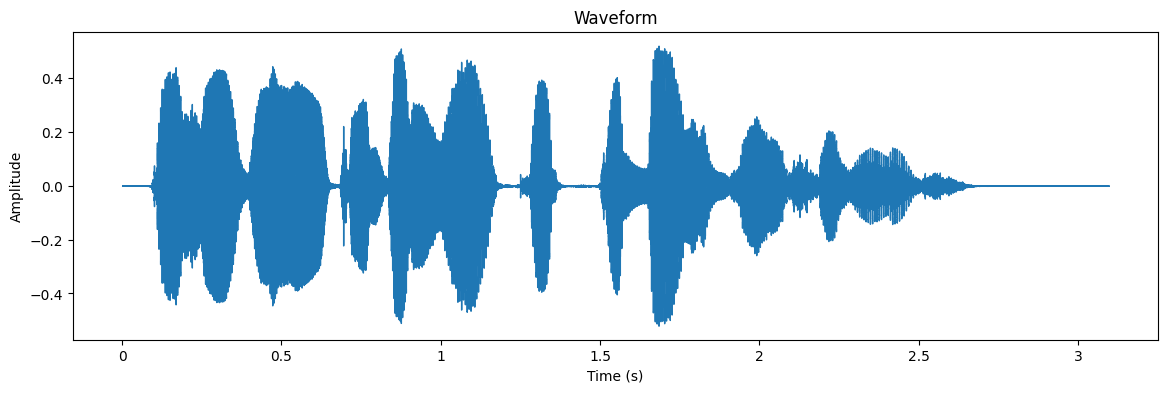

In [37]:
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

- **Visualizes the Raw Waveform Amplitude over Time.**
- **Helps detect:**
    - **Silence**
    - **Clipping**
    - **Distortion**
    - **Abnormal Signal Patterns**

**This is a signal integrity check before feature extraction.**

# **Mel Spectrogram**

In [38]:
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=sr//2)

**Converts the waveform into a Mel Spectrogram.**

- **n_mels=128:** Number of Mel Frequency Bands (captures fine speech details).
- **fmax=sr//2:** Uses Nyquist Frequency (Maximum Valid Frequency).

**Mel spectrograms are widely used because they reflect human auditory perception.**

In [39]:
mel_db = librosa.power_to_db(mel_spec, ref=np.max)

- **Converts Power Values to Logarithmic (dB) Scale.**
- **Improves:**
   - **Dynamic range compression**
   - **Numerical stability**
   - **ML model performance**

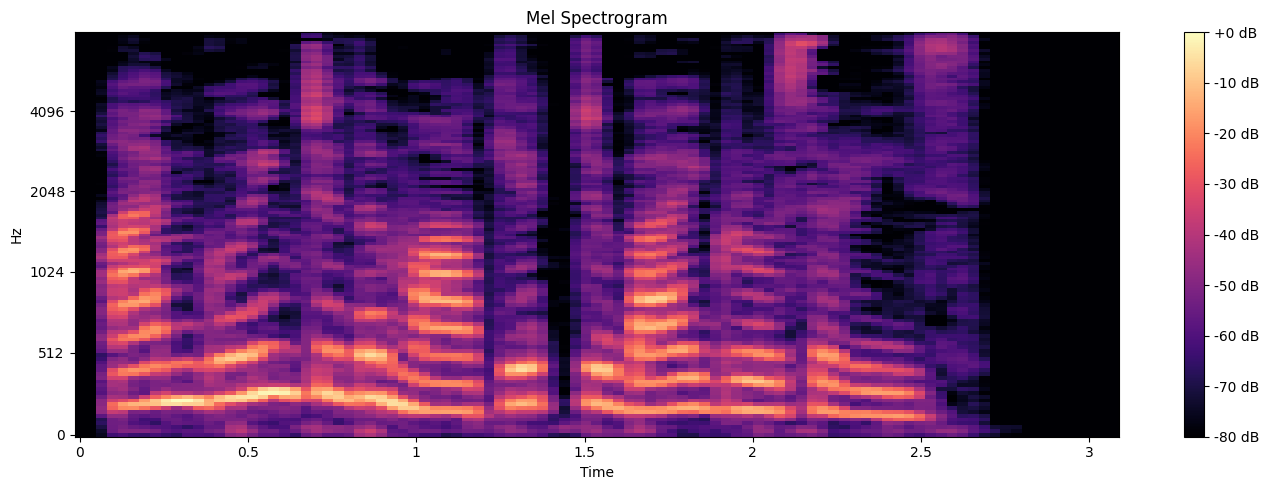

In [40]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.tight_layout()
plt.show()

- **Displays Time–Frequency Energy Distribution.**
- **Allows visual inspection of:**
    - **Pitch consistency**
    - **Spectral smoothness**
    - **Artifacts often present in AI-generated voices**

**This helps validate feature quality before modeling.**

In [41]:
print("Mel Spectrogram Shape:", mel_db.shape)
print("Minimum Value:", mel_db.min())
print("Maximum Value:", mel_db.max())

Mel Spectrogram Shape: (128, 97)
Minimum Value: -80.0
Maximum Value: 0.0


- **Confirms:**
    - **Expected feature dimensions**
    - **No NaN or extreme values**
- **Ensures the extracted features are numerically valid and stable.**

In [42]:
feature_vector = np.mean(mel_db, axis=1)
print("Feature Vector Shape:", feature_vector.shape)

Feature Vector Shape: (128,)


- **Aggregates Mel features over time using mean pooling.**
- **Converts variable-length spectrogram into a fixed-size vector.**
- **Required for classical ML models like: SVM, Random Forest, Logistic Regression**

# **MFCC**

In [43]:
# MFCC Extraction
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)

In [44]:
print("MFCC Shape:", mfcc.shape)

MFCC Shape: (13, 97)


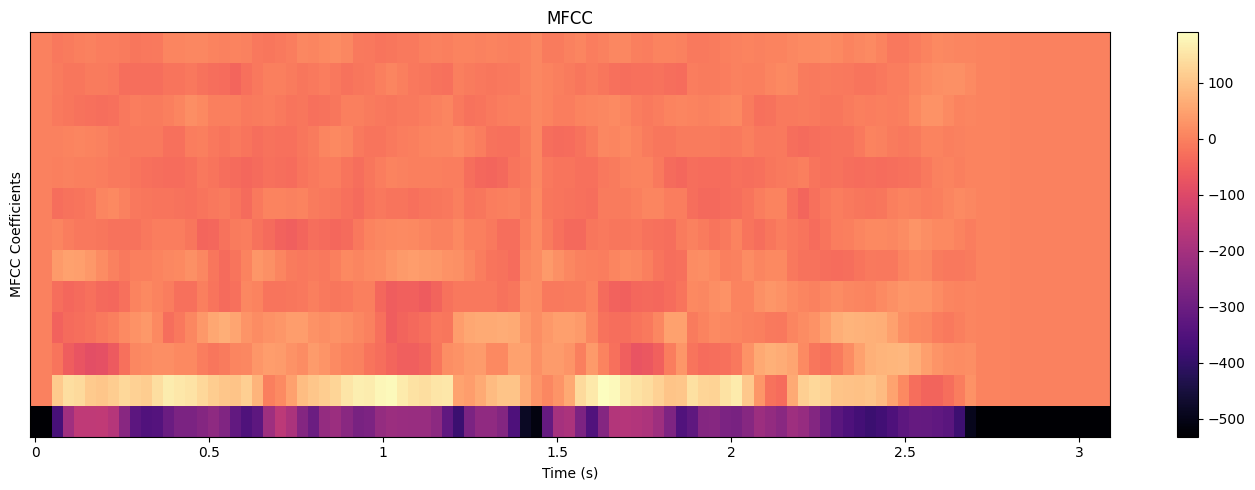

In [45]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc, sr=sr, x_axis="time", cmap="magma")
plt.colorbar()
plt.title("MFCC")
plt.ylabel("MFCC Coefficients")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [46]:
mfcc_mean = np.mean(mfcc, axis=1)
mfcc_std = np.std(mfcc, axis=1)

print("MFCC Mean Shape:", mfcc_mean.shape)
print("MFCC Std Shape:", mfcc_std.shape)

MFCC Mean Shape: (13,)
MFCC Std Shape: (13,)


# **Normalization**

In [47]:
y = librosa.util.normalize(y)
print(f"Max Amplitude after Normalization: {np.max(np.abs(y)):.3f}")

Max Amplitude after Normalization: 1.000


- **Normalizes Waveform Amplitude to [-1, 1].**
- **Prevents Amplitude-based Bias in Feature Extraction.**
- **Ensures consistency across different recording volumes.**